In [1]:
!pip install catboost

In [0]:
# The essentials
import pandas as pd
import numpy as np

from collections import defaultdict

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, GridSearchCV

from collections import defaultdict, Counter
from scipy.stats import norm

import datetime

import glob

import shap

In [3]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
final_phase_labels_15_14.csv
final_phase_labels_15_15.csv
final_phase_labels_15_1.csv
final_phase_labels_15_2.csv
final_phase_labels_15_3.csv
final_phase_labels_15_6.csv
final_phase_labels_15_7.csv
final_phase_labels_3_1.csv
final_phase_labels_3_2.csv
final_phase_labels_3_3.csv
final_phase_labels_9_8.csv
hcsta_features_3_3.csv
last_cleaned_test.csv
last_cleaned_train.csv
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
model_per_recipe_simple.csv
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_15_15.c

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

def get_corr_features(X):
  row_idx, col_idx = np.where(X.corr() == 1)
  self_corr = set([(i, i) for i in range(X.shape[1])])
  return set(list(zip(row_idx, col_idx))) - self_corr 

def get_uncorr_features(data):
  X_train_corr = data.copy()
  correlated_features = get_corr_features(X_train_corr)
  
  corr_cols = set()
  for row_idx, col_idx in correlated_features:
    corr_cols.add(row_idx)
    corr_cols.add(col_idx)
  
  uncorr_cols = list(set(X_train_corr.columns) - set(X_train_corr.columns[list(corr_cols)]))
   
  col_mask = [False]*X_train_corr.shape[1]
  for col in corr_cols:
    col_mask[col] = True
  X_train_corr = X_train_corr.loc[:, col_mask]
  
  correlated_features = get_corr_features(X_train_corr)
  
  while correlated_features:
    print('{} correlated feature pairs left...'.format(len(correlated_features)))
    corr_row, corr_col = correlated_features.pop()
    col_mask = [True]*X_train_corr.shape[1]
    col_mask[corr_row] = False
    X_train_corr = X_train_corr.loc[:, col_mask]
    correlated_features = get_corr_features(X_train_corr)
  return list(set(list(X_train_corr.columns) + uncorr_cols))

def remove_features(data, target, p_val=0.25):
  single_cols = list(data.columns[data.nunique() == 1])
  
  uncorr_cols = get_uncorr_features(data)
  corr_cols = list(set(data.columns) - set(uncorr_cols))
  
  return list(set(single_cols + corr_cols))

In [5]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')
all_data = pd.concat([train_df, test_df], axis=0)

train_df = train_df[train_df['phase'] != 'final_rinse']

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)

recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse_num'] = recipe_df['pre_rinse'] * 1
recipe_df['caustic_num'] = recipe_df['caustic'] * 2
recipe_df['intermediate_rinse_num'] = recipe_df['intermediate_rinse'] * 4
recipe_df['acid_num'] = recipe_df['acid'] * 8
recipe_df['recipe'] = recipe_df['pre_rinse_num'] + recipe_df['caustic_num'] + recipe_df['intermediate_rinse_num'] + recipe_df['acid_num']

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


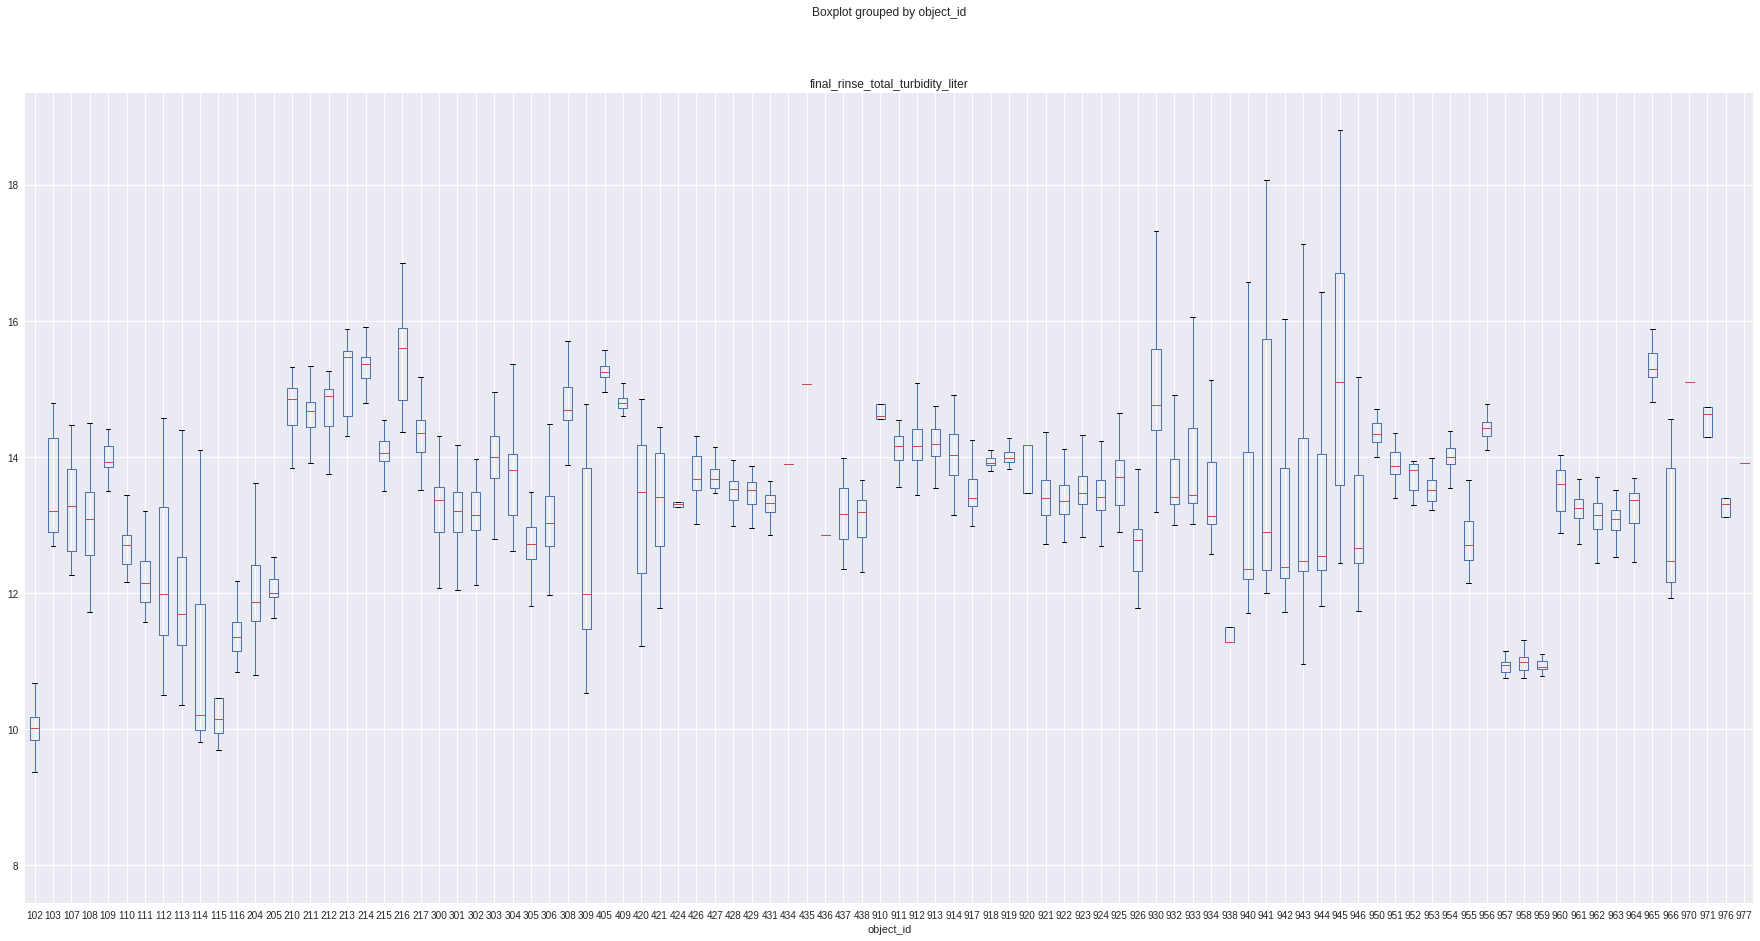

In [18]:
f, ax = plt.subplots(1, 1, figsize=(30,15))
train_df.merge(np.log(label_df), left_on='process_id', right_index=True).boxplot(by='object_id', column='final_rinse_total_turbidity_liter', ax=ax)
plt.show()

In [13]:
real_processes = set(train_df[train_df['object_id'].isin([940, 941, 942, 943, 944, 946])]['process_id'])
recipe_df.loc[real_processes]

,pre_rinse,caustic,intermediate_rinse,acid,pre_rinse_num,caustic_num,intermediate_rinse_num,acid_num,recipe
process_id,,,,,,,,,
22530,1,1,1,1,1,2,4,8,15
24583,1,0,0,1,1,0,0,8,9
22536,1,1,1,1,1,2,4,8,15
22541,1,1,1,1,1,2,4,8,15
26639,1,1,1,1,1,2,4,8,15
26640,1,0,0,1,1,0,0,8,9
26644,1,0,0,1,1,0,0,8,9
22557,1,1,1,1,1,2,4,8,15
26654,1,1,1,1,1,2,4,8,15
